<a href="https://colab.research.google.com/github/tarek3laa/cifar10/blob/master/cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**import libiares**

In [ ]:
!pip install livelossplot

In [ ]:
from matplotlib import pyplot as plt
%matplotlib inline

from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical

from keras import layers as L, Sequential,optimizers,losses
from keras.callbacks import ModelCheckpoint,Callback,ReduceLROnPlateau,EarlyStopping
from keras.applications import ResNet50V2

from keras import backend as K
from keras import datasets
from livelossplot import PlotLossesKeras

import os
import numpy as np

#**loading and exploring dataset**

In [ ]:
(X_train, y_train), (X_test, y_test) = datasets.cifar10.load_data()

In [ ]:
n = len(X_test)//2
X_val = X_test[0:n]
y_val = y_test[0:n]

X_test = X_test[n:]
y_test = y_test[n:]

In [ ]:
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

In [ ]:
print("X_train shape: %s" % (str(X_train.shape)))
print("y_train shape: %s\n" % (str(y_train.shape)))

print("X_val shape: %s" % (str(X_val.shape)))
print("y_val shape: %s\n" % (str(y_val.shape)))

print("X_val shape: %s" % (str(X_test.shape)))
print("y_val shape: %s" % (str(y_test.shape)))

X_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 10)

X_val shape: (5000, 32, 32, 3)
y_val shape: (5000, 10)

X_val shape: (5000, 32, 32, 3)
y_val shape: (5000, 10)


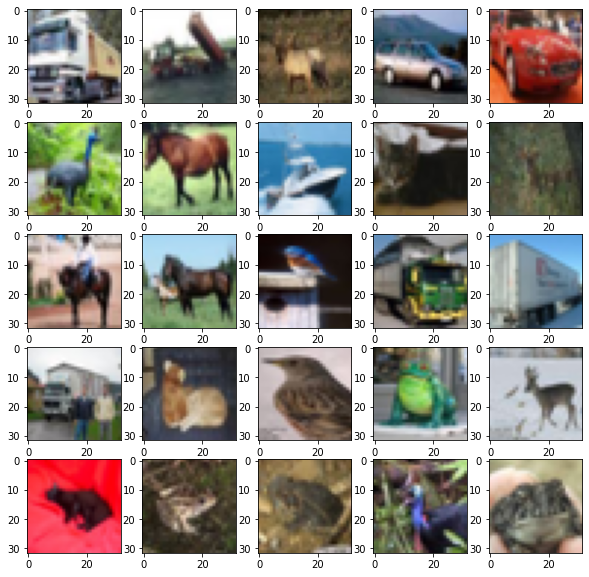

In [ ]:
fig=plt.figure(figsize=(10, 10))
columns = 5
rows = 5
for i in range(1, columns*rows +1):
    index = np.random.randint(0,len(X_train))
    fig.add_subplot(rows, columns, i)
    plt.imshow(X_train[i])

#**Preparing Images**


In [ ]:
train_gen = ImageDataGenerator(rotation_range=45, width_shift_range=0.2, 
                                shear_range=0.1,
                                height_shift_range=0.2, 
                                zoom_range=0.2,
                                horizontal_flip=True,
                                samplewise_center=True,
                                samplewise_std_normalization= True
                               )

val_gen = ImageDataGenerator(
                              samplewise_center=True,
                              samplewise_std_normalization= True
                            )

val_gen.fit(ImageDataGenerator().flow(X_train, y_train, batch_size=200,shuffle=True).next()[0])

train_batches = train_gen.flow(X_train, y_train, batch_size=64)
val_batches = val_gen.flow(X_val, y_val, batch_size=64)
test_batches = val_gen.flow(X_test,y_test,batch_size=64)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

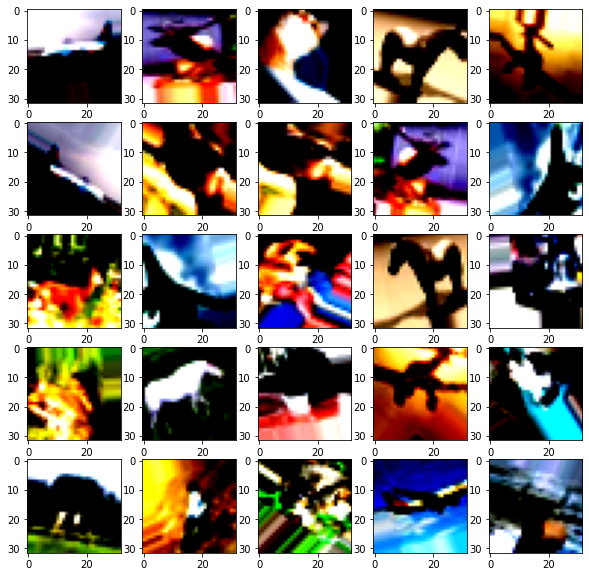

In [ ]:
fig=plt.figure(figsize=(10, 10))
columns = 5
rows = 5
for i in range(1, columns*rows +1):
    index = np.random.randint(0,64)
    fig.add_subplot(rows, columns, i)
    x, y = train_batches.__getitem__(index)
    plt.imshow(x[index])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

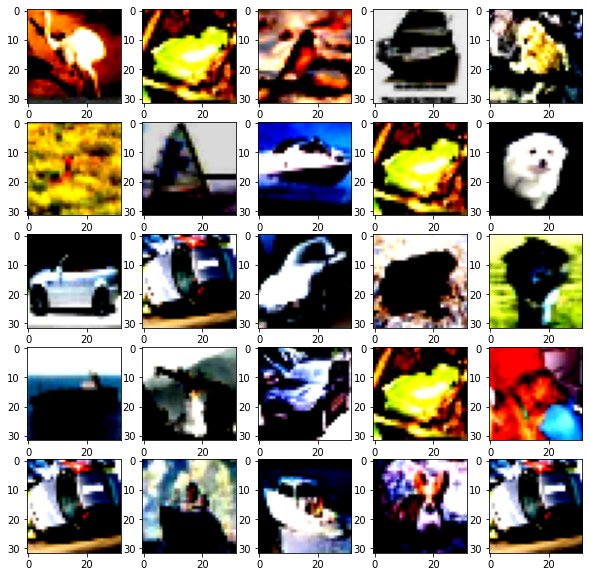

In [ ]:
fig=plt.figure(figsize=(10, 10))
columns = 5
rows = 5
for i in range(1, columns*rows +1):
    index = np.random.randint(0,64)
    fig.add_subplot(rows, columns, i)
    x, y = val_batches.__getitem__(index)
    plt.imshow(x[index])

# **Define the model**

In [ ]:
base_model = ResNet50V2(include_top=False,weights="imagenet",input_shape=(32, 32, 3),pooling='avg')

In [ ]:
base_model.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 38, 38, 3)    0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 16, 16, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 18, 18, 64)   0           conv1_conv[0][0]                 
_________________________________________________________________________________________

In [ ]:
base_model.trainable = False

In [ ]:
def get_model():
  model = Sequential()
  model.add(base_model)
  model.add(L.Dropout(0.35))
  model.add(L.Dense(512,activation='relu'))
  model.add(L.Dropout(0.25))
  model.add(L.Dense(1024,activation='relu'))
  model.add(L.Dropout(0.25))
  model.add(L.Dense(10,activation='softmax'))
  return model

In [ ]:
model = get_model()

In [ ]:
INIT_LR = 0.001
model.compile(optimizer=optimizers.Adamax(INIT_LR), loss=losses.categorical_crossentropy,
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 2048)              23564800  
_________________________________________________________________
dropout_3 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              525312    
_________________________________________________________________
dropout_5 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)               

#**Training**

In [ ]:
lr_reduction =  ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.8,
    patience=2,
    verbose=1,
    mode="auto",
    min_lr=0.000001)
earlyStopping = EarlyStopping(min_delta=1e-3,patience=5,verbose=1,restore_best_weights=True)
# callback for printing of actual learning rate used by optimizer
class LrHistory(Callback):
    def on_epoch_begin(self, epoch, logs={}):
        print("Learning rate:", K.get_value(model.optimizer.lr))

In [ ]:
check_point = ModelCheckpoint('/content/drive/My Drive/Colab Notebooks/cifar10/ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5',monitor ='val_loss',save_best_only=True)

In [ ]:
model.load_weights('/content/drive/My Drive/Colab Notebooks/cifar10/ep001-loss0.604-val_loss0.970.h5')

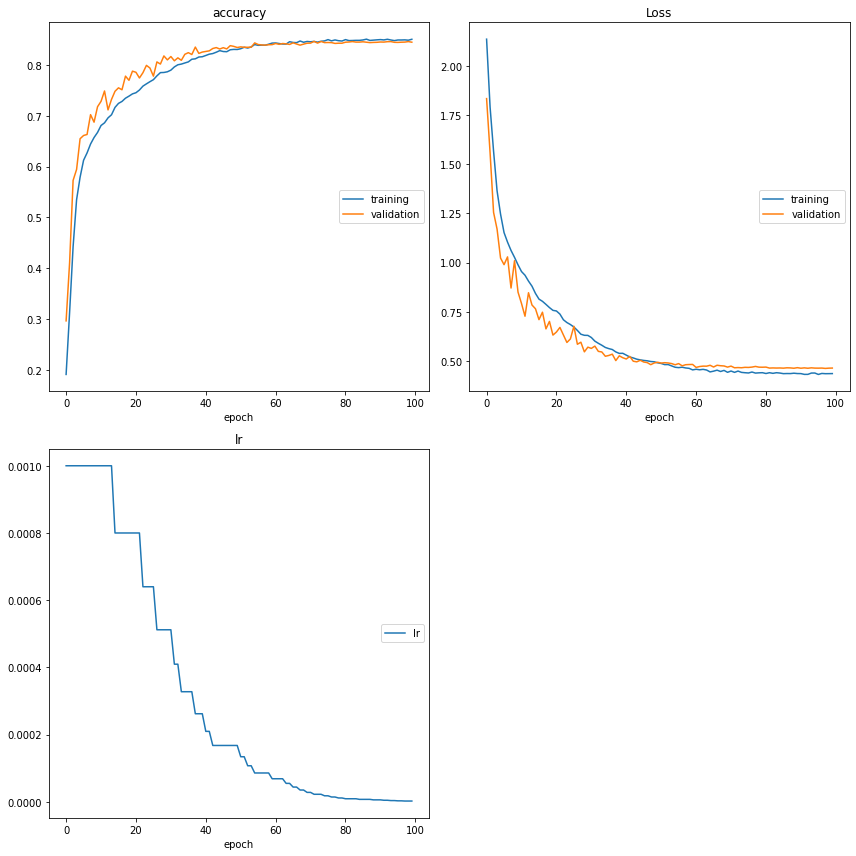

accuracy
	training         	 (min:    0.191, max:    0.851, cur:    0.851)
	validation       	 (min:    0.296, max:    0.846, cur:    0.845)
Loss
	training         	 (min:    0.431, max:    2.137, cur:    0.436)
	validation       	 (min:    0.462, max:    1.834, cur:    0.464)
lr
	lr               	 (min:    0.000, max:    0.001, cur:    0.000)
782/782 [==============================] - 48s 62ms/step - loss: 0.4356 - accuracy: 0.8506 - val_loss: 0.4636 - val_accuracy: 0.8448


In [ ]:
history = model.fit(train_batches,epochs=100,validation_data=val_batches,callbacks=[check_point,
                                                                             lr_reduction,
                                                                             LrHistory(),
                                                                             PlotLossesKeras()
                                                                             ])

In [ ]:
model.evaluate(train_batches)

782/782 [==============================] - 37s 47ms/step - loss: 0.3996 - accuracy: 0.8618


[0.39958456158638, 0.861840009689331]